In [42]:
import pandas as pd
import numpy as np
import math 
import sys, os
import urllib.request
import tmdbsimple as tmdb
from IPython.display import display, HTML, Image
import pyspark
from pyspark.sql import SQLContext
from pyspark.mllib.recommendation import ALS,MatrixFactorizationModel, Rating
from pyspark.ml.evaluation import RegressionEvaluator
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras import layers

from keras.layers.merge import concatenate
from keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt


Using TensorFlow backend.


If fails spark, type these two lines in the terminal 

export SPARK_HOME="/usr/local/Cellar/apache-spark/2.4.0/libexec/"

export JAVA_HOME=`/usr/libexec/java_home -v 1.8`

export PYSPARK_PYTHON=python3

## step 1 DATA engineering 

In [3]:
os.listdir()

['.DS_Store',
 '.ipynb_checkpoints',
 'all_stocks_5yr.csv',
 'customer_data.pkl',
 'data',
 'DS_Store',
 'Movie_recommendation',
 'Movie_recommendation.zip',
 'Recommendation System.ipynb',
 'recommendation_screen_recording_2.mp4',
 'recording1.mov',
 'recording1.mov.crdownload',
 'step1_data_engineering (1).ipynb',
 'step1_data_engineering.ipynb',
 'step2_customer_data_generation.ipynb',
 'step5_featureMatrix.pkl']

In [4]:
if "data" not in os.listdir():
    os.mkdir("data")
    os.mkdir("data/posters")
    print("Create new folder to save data")

In [5]:
ratingDataUrl = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

In [6]:
os.listdir("data")

['.DS_Store',
 '505.jpg',
 'ml-latest-small',
 'ml-latest-small.zip',
 'posters',
 'rating.csv']

In [7]:
if "ml-latest-small.zip" not in os.listdir("data"):
    urllib.request.urlretrieve(ratingDataUrl,"data/ml-latest-small.zip")
    os.system("unzip -a -n data/ml-latest-small.zip -d data/")

In [8]:
os.listdir("data")

['.DS_Store',
 '505.jpg',
 'ml-latest-small',
 'ml-latest-small.zip',
 'posters',
 'rating.csv']

In [2]:
rating_df = pd.read_csv('data/ml-latest-small/ratings.csv')
linkes_df = pd.read_csv('data/ml-latest-small/links.csv')

In [3]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [11]:
linkes_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [3]:
df_merged = pd.merge(rating_df,linkes_df,on=['movieId'])
df_merged.dropna(how="any",inplace=True)
df_merged[['tmdbId']] = df_merged[['tmdbId']].astype(int)

df_merged.head()

,userId,movieId,rating,timestamp,imdbId,tmdbId
0,1,1,4.0,964982703,114709,862
1,5,1,4.0,847434962,114709,862
2,7,1,4.5,1106635946,114709,862
3,15,1,2.5,1510577970,114709,862
4,17,1,4.5,1305696483,114709,862


In [13]:
df_merged.to_csv('data/rating.csv')

In [14]:
tmdbBase = 'http://image.tmdb.org/t/p/w185/' 
key_v3 = '10f40f0d5d794e4bacb266188128a896'

In [15]:
def get_poster_link(id,tmdb):
    tmdb.API_KEY = key_v3
    count = 1
    while count < 3:
        try:
            tmdbBase = 'http://image.tmdb.org/t/p/w185/' 
            movieInfo = tmdb.Movies(id).info()
            posterLink = movieInfo['poster_path']
            fullLink = tmdbBase + posterLink
            return fullLink,movieInfo
        except:
            count += 1
    return None

In [16]:
link, info = get_poster_link(505,tmdb=tmdb)

In [17]:
link

'http://image.tmdb.org/t/p/w185//fJBea43DpS6BhL9ZTBDoTNMiOG6.jpg'

In [18]:
info

{'adult': False,
 'backdrop_path': '/v7baGyne7CsLxnM2maMwIxKZdVF.jpg',
 'belongs_to_collection': None,
 'budget': 20000000,
 'genres': [{'id': 80, 'name': 'Crime'}, {'id': 18, 'name': 'Drama'}],
 'homepage': None,
 'id': 505,
 'imdb_id': 'tt0097626',
 'original_language': 'en',
 'original_title': 'Johnny Handsome',
 'overview': 'A career criminal who has been deformed since birth is given a new face by a kindly doctor and paroled from prison. It appears that he has gone straight, but he is really planning his revenge on the man who killed his mentor and sent him to prison.',
 'popularity': 6.851,
 'poster_path': '/fJBea43DpS6BhL9ZTBDoTNMiOG6.jpg',
 'production_companies': [{'id': 276,
   'logo_path': None,
   'name': 'Guber/Peters Company',
   'origin_country': ''},
  {'id': 277,
   'logo_path': None,
   'name': 'Roven Productions',
   'origin_country': ''},
  {'id': 275,
   'logo_path': '/2MxNWlN5b3UXt1OfmznsWEQzFwq.png',
   'name': 'Carolco Pictures',
   'origin_country': 'US'}],
 'p

In [20]:
def scrape_poster(id,tmdb,target_folder="data/posters/"):
    try:
        posterLink = get_poster_link(id,tmdb)[0]
    except:
        print(f"Unable to scrape data for poster :{id}")
        return 
    if posterLink:
        #if "data/posters/{}.jpg".format(id) not in os.listdir("data/posters"):
        urllib.request.urlretrieve(posterLink, f"{target_folder}{id}.jpg")
        print(f'Poster {id} successfully downloaded')

In [87]:
TMDBIds = df_merged.tmdbId.unique()
links_loop = []
for Id in TMDBIds:
    tmp = scrape_poster(id=Id,tmdb=tmdb)
    if tmp:    
        links_loop.append(tmp)

Poster 862 successfully downloaded
Poster 15602 successfully downloaded
Poster 949 successfully downloaded
Poster 807 successfully downloaded
Poster 629 successfully downloaded
Poster 755 successfully downloaded
Poster 13685 successfully downloaded
Poster 197 successfully downloaded
Poster 11780 successfully downloaded
Poster 1775 successfully downloaded
Poster 8068 successfully downloaded
Poster 11017 successfully downloaded
Poster 2292 successfully downloaded
Poster 8467 successfully downloaded
Poster 522 successfully downloaded
Poster 11 successfully downloaded
Poster 680 successfully downloaded
Poster 2164 successfully downloaded
Poster 11381 successfully downloaded
Poster 9331 successfully downloaded
Poster 13 successfully downloaded
Poster 10714 successfully downloaded
Poster 854 successfully downloaded
Poster 178 successfully downloaded
Poster 9571 successfully downloaded
Poster 5503 successfully downloaded
Poster 329 successfully downloaded
Poster 788 successfully downloaded
Po

Poster 10276 successfully downloaded
Poster 1857 successfully downloaded
Poster 651 successfully downloaded
Poster 278 successfully downloaded
Poster 489 successfully downloaded
Poster 24 successfully downloaded
Poster 1538 successfully downloaded
Poster 9718 successfully downloaded
Poster 1422 successfully downloaded
Poster 155 successfully downloaded
Poster 12133 successfully downloaded
Poster 16869 successfully downloaded
Poster 19908 successfully downloaded
Poster 11324 successfully downloaded
Poster 39452 successfully downloaded
Poster 27205 successfully downloaded
Poster 23168 successfully downloaded
Poster 44639 successfully downloaded
Poster 45523 successfully downloaded
Poster 59440 successfully downloaded
Poster 49026 successfully downloaded
Poster 65754 successfully downloaded
Poster 68718 successfully downloaded
Poster 106646 successfully downloaded
Poster 157336 successfully downloaded
Poster 244786 successfully downloaded
Poster 154400 successfully downloaded
Poster 26466

Poster 10778 successfully downloaded
Poster 671 successfully downloaded
Poster 1433 successfully downloaded
Poster 8342 successfully downloaded
Poster 9598 successfully downloaded
Poster 687 successfully downloaded
Poster 9603 successfully downloaded
Poster 568 successfully downloaded
Poster 414 successfully downloaded
Poster 628 successfully downloaded
Poster 9587 successfully downloaded
Poster 4476 successfully downloaded
Poster 527 successfully downloaded
Poster 11450 successfully downloaded
Poster 3049 successfully downloaded
Poster 8587 successfully downloaded
Unable to scrape data for poster :36955
Unable to scrape data for poster :2758
Poster 9386 successfully downloaded
Poster 1245 successfully downloaded
Poster 11236 successfully downloaded
Poster 10445 successfully downloaded
Poster 280 successfully downloaded
Poster 408 successfully downloaded
Poster 114 successfully downloaded
Poster 8844 successfully downloaded
Poster 31357 successfully downloaded
Poster 11862 successfully

Poster 12656 successfully downloaded
Poster 25969 successfully downloaded
Poster 9103 successfully downloaded
Poster 12233 successfully downloaded
Poster 23449 successfully downloaded
Poster 36355 successfully downloaded
Poster 9304 successfully downloaded
Poster 16299 successfully downloaded
Poster 9879 successfully downloaded
Poster 7095 successfully downloaded
Poster 41225 successfully downloaded
Poster 10545 successfully downloaded
Poster 44535 successfully downloaded
Poster 10779 successfully downloaded
Poster 38223 successfully downloaded
Poster 9294 successfully downloaded
Poster 12606 successfully downloaded
Poster 2925 successfully downloaded
Poster 18555 successfully downloaded
Poster 10830 successfully downloaded
Poster 3573 successfully downloaded
Poster 10546 successfully downloaded
Poster 9431 successfully downloaded
Poster 47907 successfully downloaded
Unable to scrape data for poster :10478
Unable to scrape data for poster :23945
Poster 9306 successfully downloaded
Post

Poster 11631 successfully downloaded
Poster 5038 successfully downloaded
Poster 12620 successfully downloaded
Poster 10764 successfully downloaded
Poster 8966 successfully downloaded
Poster 10201 successfully downloaded
Poster 10184 successfully downloaded
Poster 14160 successfully downloaded
Poster 18240 successfully downloaded
Poster 767 successfully downloaded
Poster 20943 successfully downloaded
Poster 24803 successfully downloaded
Poster 24684 successfully downloaded
Poster 22947 successfully downloaded
Poster 4475 successfully downloaded
Poster 18239 successfully downloaded
Poster 34653 successfully downloaded
Poster 10198 successfully downloaded
Poster 19995 successfully downloaded
Poster 10528 successfully downloaded
Poster 32856 successfully downloaded
Poster 37565 successfully downloaded
Poster 24021 successfully downloaded
Poster 20352 successfully downloaded
Poster 37735 successfully downloaded
Poster 38357 successfully downloaded
Poster 45269 successfully downloaded
Poster

Poster 1417 successfully downloaded
Poster 10193 successfully downloaded
Poster 562 successfully downloaded
Poster 335 successfully downloaded
Poster 240 successfully downloaded
Poster 1578 successfully downloaded
Poster 9277 successfully downloaded
Poster 157 successfully downloaded
Poster 117 successfully downloaded
Poster 1621 successfully downloaded
Poster 10158 successfully downloaded
Poster 996 successfully downloaded
Poster 938 successfully downloaded
Poster 1648 successfully downloaded
Poster 598 successfully downloaded
Poster 322 successfully downloaded
Poster 9461 successfully downloaded
Poster 4935 successfully downloaded
Poster 12163 successfully downloaded
Poster 13475 successfully downloaded
Poster 37799 successfully downloaded
Poster 45317 successfully downloaded
Poster 44264 successfully downloaded
Poster 6075 successfully downloaded
Poster 9739 successfully downloaded
Poster 319 successfully downloaded
Poster 8840 successfully downloaded
Poster 627 successfully downloa

Poster 127585 successfully downloaded
Poster 194662 successfully downloaded
Poster 250658 successfully downloaded
Poster 171372 successfully downloaded
Poster 246400 successfully downloaded
Poster 205596 successfully downloaded
Poster 131631 successfully downloaded
Poster 266856 successfully downloaded
Poster 228970 successfully downloaded
Poster 99861 successfully downloaded
Poster 102899 successfully downloaded
Poster 283995 successfully downloaded
Poster 271110 successfully downloaded
Unable to scrape data for poster :202249
Poster 320007 successfully downloaded
Poster 188927 successfully downloaded
Poster 281957 successfully downloaded
Poster 296313 successfully downloaded
Poster 276907 successfully downloaded
Poster 314365 successfully downloaded
Poster 259985 successfully downloaded
Poster 291343 successfully downloaded
Poster 318846 successfully downloaded
Unable to scrape data for poster :370646
Poster 140554 successfully downloaded
Poster 1659 successfully downloaded
Poster 16

Poster 431 successfully downloaded
Poster 12626 successfully downloaded
Poster 37818 successfully downloaded
Poster 3525 successfully downloaded
Poster 2028 successfully downloaded
Poster 16384 successfully downloaded
Poster 47947 successfully downloaded
Poster 18282 successfully downloaded
Poster 11082 successfully downloaded
Poster 20096 successfully downloaded
Poster 30815 successfully downloaded
Poster 9877 successfully downloaded
Poster 11071 successfully downloaded
Poster 8916 successfully downloaded
Poster 10377 successfully downloaded
Poster 11932 successfully downloaded
Poster 9445 successfully downloaded
Poster 2657 successfully downloaded
Poster 9945 successfully downloaded
Poster 10663 successfully downloaded
Poster 14444 successfully downloaded
Poster 9487 successfully downloaded
Poster 8130 successfully downloaded
Poster 9749 successfully downloaded
Poster 14628 successfully downloaded
Poster 13698 successfully downloaded
Poster 10466 successfully downloaded
Poster 200 su

Poster 11688 successfully downloaded
Poster 711 successfully downloaded
Poster 1493 successfully downloaded
Poster 15739 successfully downloaded
Poster 9816 successfully downloaded
Poster 19933 successfully downloaded
Poster 19405 successfully downloaded
Poster 6073 successfully downloaded
Poster 10054 successfully downloaded
Poster 1734 successfully downloaded
Poster 9476 successfully downloaded
Unable to scrape data for poster :9705
Unable to scrape data for poster :10865
Unable to scrape data for poster :1995
Unable to scrape data for poster :9799
Unable to scrape data for poster :11826
Unable to scrape data for poster :2114
Unable to scrape data for poster :78248
Poster 12144 successfully downloaded
Poster 331 successfully downloaded
Poster 2770 successfully downloaded
Poster 2294 successfully downloaded
Poster 2034 successfully downloaded
Poster 32567 successfully downloaded
Poster 10866 successfully downloaded
Poster 12780 successfully downloaded
Poster 1018 successfully download

Poster 351964 successfully downloaded
Poster 295964 successfully downloaded
Poster 309809 successfully downloaded
Unable to scrape data for poster :369879
Unable to scrape data for poster :362886
Unable to scrape data for poster :316727
Unable to scrape data for poster :400411
Poster 313369 successfully downloaded
Poster 384682 successfully downloaded
Poster 335797 successfully downloaded
Poster 324552 successfully downloaded
Poster 327253 successfully downloaded
Poster 3116 successfully downloaded
Poster 1051 successfully downloaded
Poster 805 successfully downloaded
Poster 9008 successfully downloaded
Poster 12509 successfully downloaded
Poster 10873 successfully downloaded
Poster 1999 successfully downloaded
Poster 11013 successfully downloaded
Poster 8051 successfully downloaded
Poster 153 successfully downloaded
Poster 9372 successfully downloaded
Poster 1777 successfully downloaded
Poster 70 successfully downloaded
Poster 613 successfully downloaded
Poster 308 successfully downlo

Poster 79 successfully downloaded
Poster 14292 successfully downloaded
Poster 11864 successfully downloaded
Poster 10940 successfully downloaded
Poster 13913 successfully downloaded
Unable to scrape data for poster :192936
Unable to scrape data for poster :876
Poster 8468 successfully downloaded
Poster 13823 successfully downloaded
Poster 16219 successfully downloaded
Poster 26142 successfully downloaded
Poster 12651 successfully downloaded
Poster 9791 successfully downloaded
Poster 11884 successfully downloaded
Poster 395 successfully downloaded
Poster 747 successfully downloaded
Poster 14337 successfully downloaded
Poster 13416 successfully downloaded
Poster 11109 successfully downloaded
Poster 1966 successfully downloaded
Poster 15397 successfully downloaded
Poster 9550 successfully downloaded
Unable to scrape data for poster :13057
Unable to scrape data for poster :21344
Unable to scrape data for poster :9588
Unable to scrape data for poster :27678
Unable to scrape data for poster 

Poster 11849 successfully downloaded
Poster 15999 successfully downloaded
Poster 2022 successfully downloaded
Poster 2671 successfully downloaded
Poster 9104 successfully downloaded
Poster 11770 successfully downloaded
Poster 30421 successfully downloaded
Poster 2332 successfully downloaded
Poster 12140 successfully downloaded
Poster 9316 successfully downloaded
Poster 11633 successfully downloaded
Poster 2652 successfully downloaded
Poster 11074 successfully downloaded
Poster 4478 successfully downloaded
Poster 10136 successfully downloaded
Poster 11418 successfully downloaded
Poster 11165 successfully downloaded
Poster 16562 successfully downloaded
Poster 14280 successfully downloaded
Poster 968 successfully downloaded
Poster 15379 successfully downloaded
Poster 10393 successfully downloaded
Poster 4985 successfully downloaded
Poster 9884 successfully downloaded
Poster 11892 successfully downloaded
Poster 936 successfully downloaded
Poster 9066 successfully downloaded
Poster 21589 su

Poster 5851 successfully downloaded
Poster 11452 successfully downloaded
Poster 6393 successfully downloaded
Poster 12154 successfully downloaded
Poster 8764 successfully downloaded
Poster 9357 successfully downloaded
Poster 16806 successfully downloaded
Poster 14361 successfully downloaded
Poster 32685 successfully downloaded
Poster 33506 successfully downloaded
Poster 16784 successfully downloaded
Poster 9981 successfully downloaded
Unable to scrape data for poster :2698
Unable to scrape data for poster :22067
Unable to scrape data for poster :10489
Unable to scrape data for poster :535
Poster 10860 successfully downloaded
Poster 10647 successfully downloaded
Poster 15592 successfully downloaded
Poster 1903 successfully downloaded
Poster 8470 successfully downloaded
Poster 10934 successfully downloaded
Poster 504 successfully downloaded
Poster 11184 successfully downloaded
Poster 1781 successfully downloaded
Poster 7859 successfully downloaded
Poster 2355 successfully downloaded
Post

Poster 30202 successfully downloaded
Poster 6522 successfully downloaded
Poster 18462 successfully downloaded
Poster 18252 successfully downloaded
Poster 18990 successfully downloaded
Poster 19483 successfully downloaded
Poster 11549 successfully downloaded
Poster 20242 successfully downloaded
Poster 10563 successfully downloaded
Poster 31582 successfully downloaded
Poster 1715 successfully downloaded
Unable to scrape data for poster :8989
Unable to scrape data for poster :13939
Unable to scrape data for poster :12518
Unable to scrape data for poster :12599
Poster 11686 successfully downloaded
Poster 9003 successfully downloaded
Poster 9064 successfully downloaded
Poster 2134 successfully downloaded
Poster 16889 successfully downloaded
Poster 10991 successfully downloaded
Poster 13166 successfully downloaded
Poster 2144 successfully downloaded
Poster 19494 successfully downloaded
Poster 11090 successfully downloaded
Poster 11906 successfully downloaded
Poster 31052 successfully downloa

Poster 11949 successfully downloaded
Poster 3176 successfully downloaded
Poster 37719 successfully downloaded
Poster 923 successfully downloaded
Poster 5902 successfully downloaded
Poster 8193 successfully downloaded
Poster 1653 successfully downloaded
Poster 11420 successfully downloaded
Poster 3509 successfully downloaded
Poster 421 successfully downloaded
Poster 13589 successfully downloaded
Unable to scrape data for poster :2295
Unable to scrape data for poster :1562
Unable to scrape data for poster :2270
Unable to scrape data for poster :14447
Unable to scrape data for poster :19833
Unable to scrape data for poster :37495
Poster 46105 successfully downloaded
Poster 167966 successfully downloaded
Poster 49517 successfully downloaded
Poster 74643 successfully downloaded
Poster 13976 successfully downloaded
Poster 80379 successfully downloaded
Poster 13930 successfully downloaded
Poster 140420 successfully downloaded
Poster 25117 successfully downloaded
Poster 185574 successfully dow

Poster 1901 successfully downloaded
Poster 120328 successfully downloaded
Poster 11431 successfully downloaded
Poster 13020 successfully downloaded
Poster 10027 successfully downloaded
Poster 9787 successfully downloaded
Poster 14278 successfully downloaded
Poster 501 successfully downloaded
Poster 9392 successfully downloaded
Unable to scrape data for poster :9005
Unable to scrape data for poster :1904
Poster 9043 successfully downloaded
Poster 29595 successfully downloaded
Poster 10773 successfully downloaded
Poster 10045 successfully downloaded
Poster 834 successfully downloaded
Poster 6877 successfully downloaded
Poster 13751 successfully downloaded
Poster 16070 successfully downloaded
Poster 7518 successfully downloaded
Poster 9767 successfully downloaded
Poster 350 successfully downloaded
Poster 1819 successfully downloaded
Poster 13508 successfully downloaded
Poster 7549 successfully downloaded
Poster 9297 successfully downloaded
Poster 7511 successfully downloaded
Poster 13075 

Poster 13364 successfully downloaded
Poster 13771 successfully downloaded
Poster 1919 successfully downloaded
Poster 2009 successfully downloaded
Poster 5708 successfully downloaded
Poster 2013 successfully downloaded
Poster 4787 successfully downloaded
Poster 7461 successfully downloaded
Poster 12184 successfully downloaded
Poster 10514 successfully downloaded
Poster 11850 successfully downloaded
Poster 10683 successfully downloaded
Unable to scrape data for poster :164721
Poster 215 successfully downloaded
Poster 663 successfully downloaded
Poster 11917 successfully downloaded
Poster 22804 successfully downloaded
Poster 41439 successfully downloaded
Poster 11517 successfully downloaded
Poster 2665 successfully downloaded
Poster 8512 successfully downloaded
Poster 14285 successfully downloaded
Poster 31225 successfully downloaded
Poster 30168 successfully downloaded
Poster 11851 successfully downloaded
Poster 10086 successfully downloaded
Poster 41823 successfully downloaded
Poster 12

Poster 37776 successfully downloaded
Poster 14248 successfully downloaded
Poster 26235 successfully downloaded
Poster 15159 successfully downloaded
Poster 13849 successfully downloaded
Poster 55773 successfully downloaded
Poster 27134 successfully downloaded
Poster 19724 successfully downloaded
Poster 19508 successfully downloaded
Poster 15423 successfully downloaded
Poster 19585 successfully downloaded
Poster 14968 successfully downloaded
Poster 18595 successfully downloaded
Poster 15400 successfully downloaded
Poster 16866 successfully downloaded
Poster 22897 successfully downloaded
Poster 23398 successfully downloaded
Poster 27390 successfully downloaded
Poster 57978 successfully downloaded
Poster 33728 successfully downloaded
Poster 19962 successfully downloaded
Poster 23023 successfully downloaded
Poster 21467 successfully downloaded
Poster 13417 successfully downloaded
Poster 4180 successfully downloaded
Poster 25846 successfully downloaded
Poster 32068 successfully downloaded
Po

Poster 152047 successfully downloaded
Poster 128756 successfully downloaded
Poster 188763 successfully downloaded
Poster 124117 successfully downloaded
Poster 22916 successfully downloaded
Poster 502616 successfully downloaded
Poster 4482 successfully downloaded
Poster 400 successfully downloaded
Poster 8447 successfully downloaded
Poster 51352 successfully downloaded
Poster 32562 successfully downloaded
Poster 4307 successfully downloaded
Poster 21588 successfully downloaded
Poster 26890 successfully downloaded
Poster 26933 successfully downloaded
Poster 11229 successfully downloaded
Poster 102461 successfully downloaded
Poster 44497 successfully downloaded
Poster 124829 successfully downloaded
Poster 20539 successfully downloaded
Poster 10549 successfully downloaded
Poster 36758 successfully downloaded
Poster 40480 successfully downloaded
Poster 2019 successfully downloaded
Poster 8850 successfully downloaded
Poster 763 successfully downloaded
Poster 814 successfully downloaded
Poste

Unable to scrape data for poster :10679
Unable to scrape data for poster :62764
Poster 75802 successfully downloaded
Poster 72197 successfully downloaded
Poster 50797 successfully downloaded
Poster 11902 successfully downloaded
Poster 29376 successfully downloaded
Poster 9305 successfully downloaded
Poster 975 successfully downloaded
Poster 145 successfully downloaded
Poster 12761 successfully downloaded
Poster 16306 successfully downloaded
Poster 20123 successfully downloaded
Poster 28978 successfully downloaded
Poster 10098 successfully downloaded
Poster 22501 successfully downloaded
Poster 962 successfully downloaded
Poster 14002 successfully downloaded
Poster 22500 successfully downloaded
Poster 643 successfully downloaded
Poster 12107 successfully downloaded
Poster 41050 successfully downloaded
Poster 21028 successfully downloaded
Poster 38360 successfully downloaded
Poster 20992 successfully downloaded
Poster 66091 successfully downloaded
Poster 22257 successfully downloaded
Post

Poster 18317 successfully downloaded
Poster 112 successfully downloaded
Poster 480 successfully downloaded
Poster 2565 successfully downloaded
Poster 11630 successfully downloaded
Poster 10491 successfully downloaded
Poster 17734 successfully downloaded
Poster 50035 successfully downloaded
Poster 14651 successfully downloaded
Poster 2103 successfully downloaded
Poster 61807 successfully downloaded
Poster 39310 successfully downloaded
Poster 12635 successfully downloaded
Poster 35233 successfully downloaded
Poster 30140 successfully downloaded
Poster 10227 successfully downloaded
Poster 11421 successfully downloaded
Poster 13907 successfully downloaded
Poster 14709 successfully downloaded
Poster 9678 successfully downloaded
Poster 10833 successfully downloaded
Poster 10956 successfully downloaded
Poster 2171 successfully downloaded
Poster 14369 successfully downloaded
Poster 11857 successfully downloaded
Poster 10985 successfully downloaded
Poster 13908 successfully downloaded
Poster 92

Poster 22317 successfully downloaded
Poster 9781 successfully downloaded
Poster 29756 successfully downloaded
Poster 30266 successfully downloaded
Poster 48750 successfully downloaded
Poster 11107 successfully downloaded
Poster 9513 successfully downloaded
Poster 30508 successfully downloaded
Poster 27582 successfully downloaded
Poster 80321 successfully downloaded
Poster 75780 successfully downloaded
Poster 179144 successfully downloaded
Poster 100241 successfully downloaded
Poster 82703 successfully downloaded
Poster 214030 successfully downloaded
Poster 157353 successfully downloaded
Poster 242095 successfully downloaded
Poster 244506 successfully downloaded
Poster 49017 successfully downloaded
Poster 293310 successfully downloaded
Poster 116149 successfully downloaded
Poster 260346 successfully downloaded
Poster 283330 successfully downloaded
Poster 265208 successfully downloaded
Poster 266396 successfully downloaded
Poster 305091 successfully downloaded
Poster 308504 successfully 

Poster 10424 successfully downloaded
Poster 23531 successfully downloaded
Poster 10875 successfully downloaded
Unable to scrape data for poster :43002
Unable to scrape data for poster :11694
Unable to scrape data for poster :10562
Unable to scrape data for poster :14295
Poster 11372 successfully downloaded
Poster 11983 successfully downloaded
Poster 21355 successfully downloaded
Poster 44853 successfully downloaded
Poster 11209 successfully downloaded
Poster 5955 successfully downloaded
Poster 2749 successfully downloaded
Poster 38805 successfully downloaded
Poster 5257 successfully downloaded
Poster 2575 successfully downloaded
Poster 26791 successfully downloaded
Poster 52654 successfully downloaded
Poster 10477 successfully downloaded
Poster 5923 successfully downloaded
Poster 21876 successfully downloaded
Poster 10808 successfully downloaded
Poster 13965 successfully downloaded
Poster 24266 successfully downloaded
Poster 41951 successfully downloaded
Poster 12610 successfully downl

Unable to scrape data for poster :6171
Unable to scrape data for poster :20978
Unable to scrape data for poster :10743
Poster 302 successfully downloaded
Poster 24348 successfully downloaded
Poster 4474 successfully downloaded
Poster 17127 successfully downloaded
Poster 27472 successfully downloaded
Poster 16535 successfully downloaded
Poster 12481 successfully downloaded
Poster 9583 successfully downloaded
Poster 39141 successfully downloaded
Poster 30072 successfully downloaded
Poster 9296 successfully downloaded
Poster 13560 successfully downloaded
Poster 32489 successfully downloaded
Poster 11697 successfully downloaded
Poster 29084 successfully downloaded
Poster 11030 successfully downloaded
Poster 17185 successfully downloaded
Poster 17295 successfully downloaded
Poster 20271 successfully downloaded
Poster 32611 successfully downloaded
Poster 15300 successfully downloaded
Poster 37302 successfully downloaded
Poster 62127 successfully downloaded
Poster 10615 successfully downloade

Poster 10034 successfully downloaded
Poster 23949 successfully downloaded
Poster 20794 successfully downloaded
Poster 11834 successfully downloaded
Poster 10656 successfully downloaded
Poster 19076 successfully downloaded
Poster 9523 successfully downloaded
Poster 4965 successfully downloaded
Poster 20620 successfully downloaded
Poster 74692 successfully downloaded
Poster 27593 successfully downloaded
Poster 13791 successfully downloaded
Poster 22910 successfully downloaded
Poster 441 successfully downloaded
Poster 11470 successfully downloaded
Poster 1282 successfully downloaded
Poster 13201 successfully downloaded
Poster 4012 successfully downloaded
Poster 16857 successfully downloaded
Poster 10394 successfully downloaded
Poster 15813 successfully downloaded
Poster 18905 successfully downloaded
Poster 33152 successfully downloaded
Poster 3780 successfully downloaded
Poster 11484 successfully downloaded
Poster 10550 successfully downloaded
Poster 9039 successfully downloaded
Poster 68

Unable to scrape data for poster :1944
Unable to scrape data for poster :11632
Unable to scrape data for poster :9829
Poster 13998 successfully downloaded
Poster 5259 successfully downloaded
Poster 21055 successfully downloaded
Poster 23479 successfully downloaded
Poster 9034 successfully downloaded
Poster 12540 successfully downloaded
Poster 13341 successfully downloaded
Poster 9310 successfully downloaded
Poster 1257 successfully downloaded
Poster 12683 successfully downloaded
Poster 8391 successfully downloaded
Poster 18620 successfully downloaded
Poster 17600 successfully downloaded
Poster 221917 successfully downloaded
Poster 1600 successfully downloaded
Poster 41801 successfully downloaded
Poster 1411 successfully downloaded
Poster 13853 successfully downloaded
Poster 15247 successfully downloaded
Poster 62204 successfully downloaded
Poster 32331 successfully downloaded
Poster 10236 successfully downloaded
Poster 14040 successfully downloaded
Poster 19958 successfully downloaded


Unable to scrape data for poster :24197
Poster 11692 successfully downloaded
Poster 11340 successfully downloaded
Poster 2662 successfully downloaded
Poster 12657 successfully downloaded
Poster 16246 successfully downloaded
Poster 12776 successfully downloaded
Poster 11918 successfully downloaded
Poster 8882 successfully downloaded
Poster 8832 successfully downloaded
Poster 36940 successfully downloaded
Poster 70074 successfully downloaded
Poster 62838 successfully downloaded
Poster 80585 successfully downloaded
Poster 56909 successfully downloaded
Poster 71668 successfully downloaded
Poster 90125 successfully downloaded
Poster 64689 successfully downloaded
Poster 173153 successfully downloaded
Poster 96936 successfully downloaded
Poster 24452 successfully downloaded
Poster 37368 successfully downloaded
Poster 118098 successfully downloaded
Poster 11298 successfully downloaded
Poster 20701 successfully downloaded
Poster 15849 successfully downloaded
Poster 40772 successfully downloaded

Poster 15384 successfully downloaded
Poster 41216 successfully downloaded
Poster 42188 successfully downloaded
Poster 49849 successfully downloaded
Poster 37958 successfully downloaded
Poster 10140 successfully downloaded
Poster 87101 successfully downloaded
Unable to scrape data for poster :333040
Poster 2 successfully downloaded
Poster 9604 successfully downloaded
Poster 9645 successfully downloaded
Poster 1825 successfully downloaded
Poster 10485 successfully downloaded
Poster 9298 successfully downloaded
Poster 438 successfully downloaded
Poster 10065 successfully downloaded
Poster 5471 successfully downloaded
Poster 791 successfully downloaded
Poster 5289 successfully downloaded
Poster 9708 successfully downloaded
Poster 9828 successfully downloaded
Poster 12177 successfully downloaded
Poster 14410 successfully downloaded
Poster 13455 successfully downloaded
Poster 12556 successfully downloaded
Poster 17134 successfully downloaded
Poster 7445 successfully downloaded
Poster 24271 s

Poster 11249 successfully downloaded
Poster 839 successfully downloaded
Poster 15301 successfully downloaded
Poster 27414 successfully downloaded
Poster 16296 successfully downloaded
Poster 17467 successfully downloaded
Poster 11067 successfully downloaded
Poster 16234 successfully downloaded
Poster 12720 successfully downloaded
Poster 10077 successfully downloaded
Poster 83 successfully downloaded
Poster 12487 successfully downloaded
Unable to scrape data for poster :13716
Poster 37527 successfully downloaded
Poster 13409 successfully downloaded
Poster 11683 successfully downloaded
Poster 1696 successfully downloaded
Poster 9923 successfully downloaded
Poster 1947 successfully downloaded
Poster 9910 successfully downloaded
Poster 9885 successfully downloaded
Poster 9568 successfully downloaded
Poster 45759 successfully downloaded
Poster 9035 successfully downloaded
Unable to scrape data for poster :10008
Poster 9656 successfully downloaded
Poster 4283 successfully downloaded
Poster 99

Poster 59861 successfully downloaded
Poster 50357 successfully downloaded
Poster 82696 successfully downloaded
Poster 75736 successfully downloaded
Poster 76757 successfully downloaded
Unable to scrape data for poster :239563
Unable to scrape data for poster :307663
Unable to scrape data for poster :241554
Unable to scrape data for poster :245703
Poster 334541 successfully downloaded
Poster 17402 successfully downloaded
Poster 16097 successfully downloaded
Poster 31911 successfully downloaded
Poster 9400 successfully downloaded
Poster 31000 successfully downloaded
Poster 37530 successfully downloaded
Poster 32060 successfully downloaded
Poster 40773 successfully downloaded
Poster 2383 successfully downloaded
Poster 26291 successfully downloaded
Poster 80287 successfully downloaded
Poster 10117 successfully downloaded
Poster 337703 successfully downloaded
Poster 394269 successfully downloaded
Poster 387426 successfully downloaded
Poster 40506 successfully downloaded
Poster 12499 success

Poster 40085 successfully downloaded
Poster 31094 successfully downloaded
Poster 980 successfully downloaded
Poster 14638 successfully downloaded
Poster 22387 successfully downloaded
Poster 28569 successfully downloaded
Poster 18509 successfully downloaded
Poster 15462 successfully downloaded
Poster 65012 successfully downloaded
Poster 19345 successfully downloaded
Poster 34615 successfully downloaded
Poster 12649 successfully downloaded
Poster 8072 successfully downloaded
Poster 12611 successfully downloaded
Poster 32054 successfully downloaded
Poster 16307 successfully downloaded
Poster 17898 successfully downloaded
Poster 40219 successfully downloaded
Poster 24746 successfully downloaded
Poster 12211 successfully downloaded
Poster 29492 successfully downloaded
Poster 11454 successfully downloaded
Poster 46029 successfully downloaded
Poster 43634 successfully downloaded
Poster 60285 successfully downloaded
Poster 11439 successfully downloaded
Poster 39312 successfully downloaded
Post

Unable to scrape data for poster :37557
Unable to scrape data for poster :46785
Unable to scrape data for poster :48787
Unable to scrape data for poster :16885
Unable to scrape data for poster :47697
Unable to scrape data for poster :171982
Unable to scrape data for poster :11028
Poster 32488 successfully downloaded
Poster 33743 successfully downloaded
Poster 26044 successfully downloaded
Poster 27362 successfully downloaded
Poster 13482 successfully downloaded
Poster 17169 successfully downloaded
Poster 19267 successfully downloaded
Poster 72277 successfully downloaded
Poster 10170 successfully downloaded
Poster 13915 successfully downloaded
Poster 16938 successfully downloaded
Poster 1126 successfully downloaded
Poster 13752 successfully downloaded
Poster 21575 successfully downloaded
Poster 44716 successfully downloaded
Poster 53596 successfully downloaded
Poster 103731 successfully downloaded
Poster 207932 successfully downloaded
Poster 27036 successfully downloaded
Poster 30341 su

Poster 11471 successfully downloaded
Poster 9732 successfully downloaded
Poster 11427 successfully downloaded
Poster 10891 successfully downloaded
Poster 11647 successfully downloaded
Poster 10214 successfully downloaded
Poster 3040 successfully downloaded
Poster 15283 successfully downloaded
Poster 9674 successfully downloaded
Poster 12700 successfully downloaded
Poster 8999 successfully downloaded
Poster 8555 successfully downloaded
Poster 14609 successfully downloaded
Poster 9906 successfully downloaded
Poster 14001 successfully downloaded
Poster 2269 successfully downloaded
Poster 14011 successfully downloaded
Poster 11910 successfully downloaded
Poster 13672 successfully downloaded
Poster 13394 successfully downloaded
Poster 194113 successfully downloaded
Poster 21641 successfully downloaded
Poster 17445 successfully downloaded
Poster 34003 successfully downloaded
Poster 10664 successfully downloaded
Poster 23437 successfully downloaded
Poster 41283 successfully downloaded
Poster 

Poster 48463 successfully downloaded
Poster 37748 successfully downloaded
Poster 14750 successfully downloaded
Poster 7548 successfully downloaded
Poster 14695 successfully downloaded
Poster 1561 successfully downloaded
Poster 3093 successfully downloaded
Poster 8998 successfully downloaded
Poster 13141 successfully downloaded
Poster 11559 successfully downloaded
Poster 13158 successfully downloaded
Poster 10294 successfully downloaded
Poster 14873 successfully downloaded
Poster 42884 successfully downloaded
Unable to scrape data for poster :151960
Unable to scrape data for poster :10989
Poster 3022 successfully downloaded
Poster 11556 successfully downloaded
Poster 11304 successfully downloaded
Poster 14748 successfully downloaded
Poster 37144 successfully downloaded
Poster 4483 successfully downloaded
Poster 21334 successfully downloaded
Poster 10239 successfully downloaded
Poster 44379 successfully downloaded
Poster 12582 successfully downloaded
Poster 31064 successfully downloaded


Poster 20210 successfully downloaded
Poster 21989 successfully downloaded
Poster 41759 successfully downloaded
Poster 36629 successfully downloaded
Poster 21413 successfully downloaded
Poster 333 successfully downloaded
Poster 22200 successfully downloaded
Poster 27590 successfully downloaded
Poster 14603 successfully downloaded
Poster 1358 successfully downloaded
Poster 10337 successfully downloaded
Poster 11707 successfully downloaded
Poster 7442 successfully downloaded
Poster 6723 successfully downloaded
Poster 13339 successfully downloaded
Poster 47866 successfully downloaded
Poster 28200 successfully downloaded
Poster 1376 successfully downloaded
Poster 11042 successfully downloaded
Poster 10021 successfully downloaded
Poster 52036 successfully downloaded
Poster 10718 successfully downloaded
Poster 40427 successfully downloaded
Poster 9548 successfully downloaded
Poster 27329 successfully downloaded
Poster 17736 successfully downloaded
Poster 8842 successfully downloaded
Poster 24

Poster 27085 successfully downloaded
Poster 19265 successfully downloaded
Poster 11115 successfully downloaded
Poster 28053 successfully downloaded
Poster 21910 successfully downloaded
Poster 22820 successfully downloaded
Poster 22640 successfully downloaded
Poster 25927 successfully downloaded
Poster 34563 successfully downloaded
Poster 31723 successfully downloaded
Poster 39053 successfully downloaded
Poster 36801 successfully downloaded
Poster 40247 successfully downloaded
Poster 40850 successfully downloaded
Poster 24122 successfully downloaded
Poster 43593 successfully downloaded
Poster 41479 successfully downloaded
Poster 38073 successfully downloaded
Poster 38031 successfully downloaded
Poster 41556 successfully downloaded
Poster 48838 successfully downloaded
Poster 42684 successfully downloaded
Poster 46829 successfully downloaded
Poster 46528 successfully downloaded
Poster 50204 successfully downloaded
Poster 50725 successfully downloaded
Poster 49494 successfully downloaded
P

Poster 344041 successfully downloaded
Poster 256687 successfully downloaded
Poster 325173 successfully downloaded
Poster 272548 successfully downloaded
Poster 323675 successfully downloaded
Poster 312669 successfully downloaded
Poster 331962 successfully downloaded
Poster 337029 successfully downloaded
Poster 340255 successfully downloaded
Poster 21266 successfully downloaded
Poster 300673 successfully downloaded
Poster 258363 successfully downloaded
Poster 20051 successfully downloaded
Poster 353609 successfully downloaded
Poster 332721 successfully downloaded
Poster 359025 successfully downloaded
Poster 315664 successfully downloaded
Poster 302688 successfully downloaded
Poster 254952 successfully downloaded
Poster 351065 successfully downloaded
Poster 301608 successfully downloaded
Poster 353326 successfully downloaded
Poster 366901 successfully downloaded
Poster 7237 successfully downloaded
Poster 303858 successfully downloaded
Poster 326423 successfully downloaded
Poster 153518 su

Poster 55727 successfully downloaded
Poster 18192 successfully downloaded
Poster 228 successfully downloaded
Poster 11414 successfully downloaded
Poster 5052 successfully downloaded
Poster 10269 successfully downloaded
Poster 31674 successfully downloaded
Poster 32499 successfully downloaded
Poster 33668 successfully downloaded
Poster 18646 successfully downloaded
Poster 38147 successfully downloaded
Poster 31805 successfully downloaded
Poster 21970 successfully downloaded
Poster 55106 successfully downloaded
Poster 28907 successfully downloaded
Poster 28577 successfully downloaded
Poster 13909 successfully downloaded
Poster 88818 successfully downloaded
Poster 43772 successfully downloaded
Poster 3640 successfully downloaded
Poster 18913 successfully downloaded
Poster 19049 successfully downloaded
Poster 5506 successfully downloaded
Poster 32568 successfully downloaded
Unable to scrape data for poster :15173
Unable to scrape data for poster :11868
Unable to scrape data for poster :108

Poster 16274 successfully downloaded
Poster 17801 successfully downloaded
Poster 38914 successfully downloaded
Poster 20246 successfully downloaded
Poster 3766 successfully downloaded
Poster 45578 successfully downloaded
Poster 43388 successfully downloaded
Poster 3111 successfully downloaded
Poster 28696 successfully downloaded
Poster 31962 successfully downloaded
Poster 16992 successfully downloaded
Poster 43442 successfully downloaded
Poster 39472 successfully downloaded
Poster 42390 successfully downloaded
Poster 57825 successfully downloaded
Poster 19765 successfully downloaded
Poster 42719 successfully downloaded
Poster 15907 successfully downloaded
Poster 25890 successfully downloaded
Poster 7509 successfully downloaded
Poster 35555 successfully downloaded
Poster 14201 successfully downloaded
Poster 18615 successfully downloaded
Poster 13967 successfully downloaded
Poster 3549 successfully downloaded
Poster 1988 successfully downloaded
Poster 12901 successfully downloaded
Poster

Unable to scrape data for poster :18884
Poster 76180 successfully downloaded
Poster 92321 successfully downloaded
Poster 17346 successfully downloaded
Poster 75301 successfully downloaded
Poster 84327 successfully downloaded
Poster 80215 successfully downloaded
Unable to scrape data for poster :212063
Unable to scrape data for poster :86705
Unable to scrape data for poster :318044
Unable to scrape data for poster :318256
Unable to scrape data for poster :324325
Unable to scrape data for poster :367735
Unable to scrape data for poster :400608
Poster 408546 successfully downloaded
Poster 411009 successfully downloaded
Poster 16729 successfully downloaded
Poster 42293 successfully downloaded
Poster 131244 successfully downloaded
Poster 258357 successfully downloaded
Poster 3934 successfully downloaded
Poster 21299 successfully downloaded
Poster 38802 successfully downloaded
Poster 82623 successfully downloaded
Poster 31514 successfully downloaded
Poster 18691 successfully downloaded
Poste

Poster 21512 successfully downloaded
Poster 33255 successfully downloaded
Poster 49689 successfully downloaded
Poster 3072 successfully downloaded
Poster 36786 successfully downloaded
Poster 47819 successfully downloaded
Poster 886 successfully downloaded
Poster 2577 successfully downloaded
Poster 42164 successfully downloaded
Poster 12088 successfully downloaded
Poster 20536 successfully downloaded
Poster 81003 successfully downloaded
Poster 48259 successfully downloaded
Poster 24575 successfully downloaded
Poster 53879 successfully downloaded
Poster 104301 successfully downloaded
Poster 12584 successfully downloaded
Poster 109560 successfully downloaded
Poster 62422 successfully downloaded
Poster 161795 successfully downloaded
Poster 37498 successfully downloaded
Poster 114719 successfully downloaded
Poster 73642 successfully downloaded
Poster 9594 successfully downloaded
Poster 47596 successfully downloaded
Poster 39176 successfully downloaded
Poster 20115 successfully downloaded
Po

Poster 2436 successfully downloaded
Poster 10951 successfully downloaded
Poster 29578 successfully downloaded
Poster 15771 successfully downloaded
Poster 22434 successfully downloaded
Poster 12778 successfully downloaded
Poster 28448 successfully downloaded
Poster 16972 successfully downloaded
Poster 9463 successfully downloaded
Poster 38643 successfully downloaded
Poster 13064 successfully downloaded
Poster 15767 successfully downloaded
Poster 12574 successfully downloaded
Poster 11309 successfully downloaded
Poster 17824 successfully downloaded
Poster 11328 successfully downloaded
Poster 10753 successfully downloaded
Poster 42000 successfully downloaded
Poster 46917 successfully downloaded
Poster 27031 successfully downloaded
Poster 79406 successfully downloaded
Poster 16433 successfully downloaded
Poster 12701 successfully downloaded
Poster 21519 successfully downloaded
Poster 1969 successfully downloaded
Poster 31894 successfully downloaded
Poster 7515 successfully downloaded
Poste

Poster 33115 successfully downloaded
Poster 21631 successfully downloaded
Poster 25119 successfully downloaded
Poster 324308 successfully downloaded
Poster 124626 successfully downloaded
Poster 89333 successfully downloaded
Poster 30157 successfully downloaded
Poster 34574 successfully downloaded
Poster 30304 successfully downloaded
Poster 87078 successfully downloaded
Poster 5879 successfully downloaded
Poster 9300 successfully downloaded
Poster 41878 successfully downloaded
Poster 124472 successfully downloaded
Poster 12652 successfully downloaded
Poster 68445 successfully downloaded
Poster 49963 successfully downloaded
Poster 23223 successfully downloaded
Poster 116844 successfully downloaded
Poster 30180 successfully downloaded
Poster 28198 successfully downloaded
Poster 28005 successfully downloaded
Poster 47694 successfully downloaded
Poster 45671 successfully downloaded
Poster 65046 successfully downloaded
Poster 32519 successfully downloaded
Poster 108401 successfully downloade

Poster 16407 successfully downloaded
Poster 11429 successfully downloaded
Poster 10347 successfully downloaded
Poster 14510 successfully downloaded
Poster 42694 successfully downloaded
Poster 17905 successfully downloaded
Poster 12637 successfully downloaded
Poster 13481 successfully downloaded
Poster 13514 successfully downloaded
Poster 63418 successfully downloaded
Poster 8852 successfully downloaded
Poster 11847 successfully downloaded
Poster 13899 successfully downloaded
Poster 27324 successfully downloaded
Poster 10361 successfully downloaded
Poster 12583 successfully downloaded
Poster 11662 successfully downloaded
Poster 34326 successfully downloaded
Poster 25074 successfully downloaded
Poster 11636 successfully downloaded
Poster 22908 successfully downloaded
Poster 28638 successfully downloaded
Poster 37939 successfully downloaded
Poster 5072 successfully downloaded
Poster 6948 successfully downloaded
Poster 10790 successfully downloaded
Poster 14240 successfully downloaded
Post

In [ ]:
"""Multiprocess version"""
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
workers = 6
with ProcessPoolExecutor(max_workers=workers) as executor:
    links_multiprocess = executor.map(scrape_poster, TMDBIds,[tmdb]*len(TMDBIds))        		

In [21]:
class scraper:
    def __init__(self,ratingLink=None):
        tmdbBase = 'http://image.tmdb.org/t/p/w185/' 
        key_v3 = '10f40f0d5d794e4bacb266188128a896'
    
        tmdb.API_KEY = key_v3
        self.tmdb = tmdb
        
        ratingLink = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip" if not ratingLink else ratingLink
        if "data" not in os.listdir():
            os.mkdir("data")
            os.mkdir("data/posters")
            print("Create new folder to save data")
        
    def download_rating(self):
        if "ml-latest-small.zip" not in os.listdir("data"):
            urllib.request.urlretrieve(self.ratingLink,"data/ml-latest-small.zip")
            os.system("unzip -a -n data/ml-latest-small.zip -d data/")
    
    def proces_rating(self):
        rating_df = pd.read_csv('data/ml-latest-small/ratings.csv')
        linkes_df = pd.read_csv('data/ml-latest-small/links.csv')
        df_merged = pd.merge(rating_df,linkes_df,on=['movieId'])
        df_merged.dropna(how="any",inplace=True)
        df_merged[['tmdbId']] = df_merged[['tmdbId']].astype(int)
        self.rating = df_merged
        return df_merged
    
    def download_posters(self,method="map",target_folder="data/poster/"):
        TMDBIds = self.rating.tmdbId.unique()
        
        if method == "map":
            list(map(lambda x:scrape_poster(id=x,target_folder=target_folder),TMDBIds))
        elif method == "multiprocess":
            workers = 6
            with ProcessPoolExecutor(max_workers=workers) as executor:
                links_multiprocess = executor.map(scrape_poster, TMDBIds)     
        elif method == 'loop':   
            for Id in TMDBIds:
                scrape_poster(id=Id)
        else:
            print("Must select a method")
            
    def get_poster_link(self,id):
        count = 1
        while count < 3:
            try:
                tmdbBase = 'http://image.tmdb.org/t/p/w185/' 
                movieInfo = self.tmdb.Movies(id).info()
                posterLink = movieInfo['poster_path']
                fullLink = tmdbBase + posterLink
                return fullLink
            except:
                count += 1
        return None
    def scrape_poster(self,id,target_folder="data/poster/"):
        posterLink = self.get_poster_link(id)
        if posterLink:
            urllib.request.urlretrieve(fullLink, f"{target_folder}{id}.jpg")
            print(f'Poster {id} successfully downloaded')
        else:
            print(f"Unable to scrape data for poster :{id}")

## Step2 ALS 

In [61]:
df = df_merged[['userId','tmdbId','rating']]
df

,userId,tmdbId,rating
0,1,862,4.0
1,5,862,4.0
2,7,862,4.5
3,15,862,2.5
4,17,862,4.5
5,18,862,3.5
6,19,862,4.0
7,21,862,3.5
8,27,862,3.0
9,31,862,5.0


In [5]:
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [6]:
df_spark = sqlContext.createDataFrame(df)
df_spark.printSchema()

root
 |-- userId: long (nullable = true)
 |-- tmdbId: long (nullable = true)
 |-- rating: double (nullable = true)



In [7]:
df_spark.show()

+------+------+------+
|userId|tmdbId|rating|
+------+------+------+
|     1|   862|   4.0|
|     5|   862|   4.0|
|     7|   862|   4.5|
|    15|   862|   2.5|
|    17|   862|   4.5|
|    18|   862|   3.5|
|    19|   862|   4.0|
|    21|   862|   3.5|
|    27|   862|   3.0|
|    31|   862|   5.0|
|    32|   862|   3.0|
|    33|   862|   3.0|
|    40|   862|   5.0|
|    43|   862|   5.0|
|    44|   862|   3.0|
|    45|   862|   4.0|
|    46|   862|   5.0|
|    50|   862|   3.0|
|    54|   862|   3.0|
|    57|   862|   5.0|
+------+------+------+
only showing top 20 rows



In [8]:
df_spark.head(5)

[Row(userId=1, tmdbId=862, rating=4.0),
 Row(userId=5, tmdbId=862, rating=4.0),
 Row(userId=7, tmdbId=862, rating=4.5),
 Row(userId=15, tmdbId=862, rating=2.5),
 Row(userId=17, tmdbId=862, rating=4.5)]

In [8]:
model = ALS.train(df_spark, 10, 10)

In [9]:
true_rating = df_spark[['rating']].rdd.map(lambda x:x[0]).collect()
true_rating[:10]

[4.0, 4.0, 4.5, 2.5, 4.5, 3.5, 4.0, 3.5, 3.0, 5.0]

In [10]:
X = df_spark[['UserId',"tmdbId"]].rdd
pred = model.predictAll(X).map(lambda x:x[2]).collect()

In [12]:
RMSE = math.sqrt(np.mean([(x-y)**2 for x,y, in zip(true_rating,pred)]))
RMSE

1.3711316722197047

In [13]:
abss = np.mean([abs(x-y) for x,y, in zip(true_rating,pred)])

In [14]:
abss

1.0787107999437617

In [16]:
productForUser = model.recommendUsers(242,10)
print("Top 10 moive recommendations for product 242: \n")
display(productForUser)

Top 10 moive recommendations for product 242: 



[Rating(user=542, product=242, rating=6.199883383284087),
 Rating(user=569, product=242, rating=6.196252340721125),
 Rating(user=197, product=242, rating=6.031985426511204),
 Rating(user=250, product=242, rating=5.726851940435935),
 Rating(user=543, product=242, rating=5.653752858744097),
 Rating(user=22, product=242, rating=5.457790565369189),
 Rating(user=259, product=242, rating=5.452836893948789),
 Rating(user=251, product=242, rating=5.4177063551231255),
 Rating(user=337, product=242, rating=5.410250928553763),
 Rating(user=116, product=242, rating=5.308861446325863)]

In [17]:
userForProduct = model.recommendProducts(196,10)
print("Top 10 users to recommend for user 196")
display(userForProduct)

Top 10 users to recommend for user 196


[Rating(user=196, product=8067, rating=9.033710446328605),
 Rating(user=196, product=16406, rating=8.775239784590093),
 Rating(user=196, product=41402, rating=8.684139373697203),
 Rating(user=196, product=11855, rating=8.41371773792627),
 Rating(user=196, product=10560, rating=8.233018293952808),
 Rating(user=196, product=62204, rating=8.161874721687852),
 Rating(user=196, product=28387, rating=8.03841393195378),
 Rating(user=196, product=168, rating=7.903601787808557),
 Rating(user=196, product=10646, rating=7.865357078948472),
 Rating(user=196, product=887, rating=7.791630908112927)]

In [18]:
ratingPredict= model.predict(196,242)
print("prediction of rate for User 196 --> stock 242")
display(ratingPredict)

prediction of rate for User 196 --> stock 242


4.226398784120612

In [20]:
class SP_ALS:
    def __init__(self):
        pass
    def train(self,df,rank=10,numIterations=15):
        assert len(df.columns) == 3
        """Create SparkContext"""
        ### You can only have one sparkContext at the same time
        sc = pyspark.SparkContext.getOrCreate()
        sqlContext = SQLContext(sc)
        """Create Spark dataframe"""
        df_spark = sqlContext.createDataFrame(df)
        
        """Train ALS model """
        self.model = ALS.train(df_spark, rank, numIterations)
        self.rmse = self.computeRmse(df_spark)
        
    def computeRmse(self,df):
        """
        Compute RMSE (Root mean Squared Error).
        """
        true_rating = df[['rating']].rdd.map(lambda x:x[0]).collect()    

        rdd_x = df[['UserId',"tmdbId"]].rdd
        pred_rating = model.predictAll(rdd_x).map(lambda x:x[2]).collect()

        MSE = np.mean([(x-y)**2 for x,y, in zip(true_rating,pred_rating)])
        RMSE = math.sqrt(MSE)
        return RMSE    
    
    def recommend_to_user(self,userId =10,num_products=10):
        return self.model.recommendProducts(userId,num_products)
    def recommend_to_products(self,productId =10,num_users=10):
        return self.model.recommendUsers(productId,num_users)
    def predict_score(self,userId,productId):
        return self.model.predict(userId,productId)
    def get_product_features(self):
        productFeatures = self.model.productFeatures()
        return productFeatures.collect()

## Step3 SVD

In [25]:
df.head()

,userId,tmdbId,rating
0,1,862,4.0
1,5,862,4.0
2,7,862,4.5
3,15,862,2.5
4,17,862,4.5


In [30]:
id_2_tmdb = {i:j for i,j in enumerate(df.tmdbId.unique())}
tmdb_2_id = {j:i for i,j in id_2_tmdb.items()}
id_2_user = {i:j for i,j in enumerate(df.userId.unique())}
user_2_id = {j:i for i,j in id_2_user.items()}

In [31]:
rating_matrix = np.zeros([len(id_2_user),len(id_2_tmdb)])

In [36]:
for row in df.itertuples():
    rawUser, rawMovie, rating = row[1], row[2], row[3]
    user, movie = user_2_id[rawUser], tmdb_2_id[rawMovie]
    
    rating_matrix[user][movie] = rating
rating_matrix

array([[4. , 4. , 4. , ..., 0. , 0. , 0. ],
       [4. , 0. , 0. , ..., 0. , 0. , 0. ],
       [4.5, 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [37]:
tf.reset_default_graph()
nb_users, nb_products = len(id_2_user), len(id_2_tmdb)
with tf.Session() as sess:
    rating_matrix_tf = tf.placeholder(tf.float32, shape=(nb_users, nb_products))
    S, U, V = tf.svd(rating_matrix_tf)
    
    s,u,v = sess.run([S,U,V],feed_dict={rating_matrix_tf:rating_matrix})

In [38]:
def svd_tf(rating_matrix):
    tf.reset_default_graph()
    nb_users, nb_products = rating_matrix.shape
    with tf.Session() as sess:
        rating_matrix_tf = tf.placeholder(tf.float32, shape=(nb_users, nb_products))
        S, U, V = tf.svd(rating_matrix_tf)

        s,u,v = sess.run([S,U,V],feed_dict={rating_matrix_tf:rating_matrix})
    return s,u,v

In [39]:
s,u,v = svd_tf(rating_matrix)

In [41]:
pred_rating_matrix = u@np.diag(s)@v.transpose()
pred_rating_matrix[0,:]

array([4.0000176e+00, 4.0000038e+00, 4.0000081e+00, ..., 2.3306347e-07,
       3.5681296e-07, 3.5681296e-07], dtype=float32)

## step 4: Deep Neural Networks 

In [62]:
df_dnn = df

In [63]:
userCol="userId"
productCol="tmdbId"

In [64]:
id_2_product = {i:j for i,j in enumerate(df_dnn[productCol].unique())}
product_2_id = {j:i for i,j in id_2_product.items()}

id_2_user = {i:j for i,j in enumerate(df_dnn[userCol].unique())}
user_2_id = {j:i for i,j in id_2_user.items()}

In [65]:
df_dnn[productCol] = df_dnn.apply(lambda x:product_2_id[x[productCol]],axis=1)
df_dnn[userCol] = df_dnn.apply(lambda x:user_2_id[x[userCol]],axis=1)

/Users/ricky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ricky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [66]:
X = df_dnn[[userCol,productCol]].values
Y = df_dnn['rating'].values

In [67]:
X1 = X[:,0].reshape(-1,1)
X2 = X[:,1].reshape(-1,1)

In [68]:
NUM_PRODUCTS = np.unique(X[:,1]).size
NUM_USERS = np.unique(X[:,0]).size
DIM_FEATURES = 10
EPOCHS = 200
BATCH_SIZE = 512
verbose = 1

In [69]:
layers.Input(shape=(1,))

<tf.Tensor 'input_4:0' shape=(?, 1) dtype=float32>

In [76]:
### input layer
input_user = layers.Input(shape=(1,))
input_product = layers.Input(shape=(1,))
in_layers = [input_user,input_product]

### Embedding layer
embed_user = layers.Embedding(NUM_USERS,DIM_FEATURES)(input_user)
embed_product = layers.Embedding(NUM_PRODUCTS,DIM_FEATURES)(input_product)

### flattern layer 
flat_user = layers.Flatten()(embed_user)
flat_product = layers.Flatten()(embed_product)

### Dot layer
dot_value = layers.dot([flat_user,flat_product],axes=1,normalize=True)

## Dense layer to get y
rating_y = layers.Dense(1,kernel_initializer='normal')(dot_value)

In [77]:
rating_model = Model(inputs=in_layers,output=rating_y)
rating_model.compile(loss="mse",optimizer="adam")

/Users/ricky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [78]:
rating_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 10)        6100        input_7[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 10)        97150       input_8[0][0]                    
__________________________________________________________________________________________________
flatten_5 

In [79]:
history = rating_model.fit(x=[X1,X2],y=Y,validation_split=0.3,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=verbose)

Train on 70576 samples, validate on 30247 samples
Epoch 1/200
70576/70576 [==============================] - 1s 15us/step - loss: 13.3678 - val_loss: 11.2848
Epoch 2/200
70576/70576 [==============================] - 1s 9us/step - loss: 11.8817 - val_loss: 10.4663
Epoch 3/200
70576/70576 [==============================] - 1s 9us/step - loss: 9.0430 - val_loss: 9.7643
Epoch 4/200
70576/70576 [==============================] - 1s 11us/step - loss: 7.3538 - val_loss: 9.1321
Epoch 5/200
70576/70576 [==============================] - 1s 9us/step - loss: 6.0878 - val_loss: 8.5583
Epoch 6/200
70576/70576 [==============================] - 1s 9us/step - loss: 5.0626 - val_loss: 8.0379
Epoch 7/200
70576/70576 [==============================] - 1s 10us/step - loss: 4.2202 - val_loss: 7.5676
Epoch 8/200
70576/70576 [==============================] - 1s 10us/step - loss: 3.5275 - val_loss: 7.1443
Epoch 9/200
70576/70576 [==============================] - 1s 9us/step - loss: 2.9614 - val_loss: 6.76

70576/70576 [==============================] - 0s 7us/step - loss: 0.3709 - val_loss: 2.8995
Epoch 78/200
70576/70576 [==============================] - 0s 6us/step - loss: 0.3705 - val_loss: 2.9094
Epoch 79/200
70576/70576 [==============================] - 1s 7us/step - loss: 0.3699 - val_loss: 2.9064
Epoch 80/200
70576/70576 [==============================] - 1s 9us/step - loss: 0.3693 - val_loss: 2.9090
Epoch 81/200
70576/70576 [==============================] - 1s 14us/step - loss: 0.3690 - val_loss: 2.9088
Epoch 82/200
70576/70576 [==============================] - 1s 10us/step - loss: 0.3685 - val_loss: 2.9104
Epoch 83/200
70576/70576 [==============================] - 1s 9us/step - loss: 0.3678 - val_loss: 2.9222
Epoch 84/200
70576/70576 [==============================] - 1s 8us/step - loss: 0.3674 - val_loss: 2.9205
Epoch 85/200
70576/70576 [==============================] - 1s 8us/step - loss: 0.3671 - val_loss: 2.9226
Epoch 86/200
70576/70576 [==============================]

70576/70576 [==============================] - 1s 8us/step - loss: 0.3510 - val_loss: 3.1340
Epoch 154/200
70576/70576 [==============================] - 1s 9us/step - loss: 0.3509 - val_loss: 3.1318
Epoch 155/200
70576/70576 [==============================] - 1s 9us/step - loss: 0.3506 - val_loss: 3.1353
Epoch 156/200
70576/70576 [==============================] - 1s 8us/step - loss: 0.3505 - val_loss: 3.1373
Epoch 157/200
70576/70576 [==============================] - 1s 9us/step - loss: 0.3503 - val_loss: 3.1421
Epoch 158/200
70576/70576 [==============================] - 1s 11us/step - loss: 0.3503 - val_loss: 3.1506
Epoch 159/200
70576/70576 [==============================] - 1s 8us/step - loss: 0.3500 - val_loss: 3.1465
Epoch 160/200
70576/70576 [==============================] - 1s 9us/step - loss: 0.3500 - val_loss: 3.1487
Epoch 161/200
70576/70576 [==============================] - 1s 10us/step - loss: 0.3501 - val_loss: 3.1515
Epoch 162/200
70576/70576 [======================

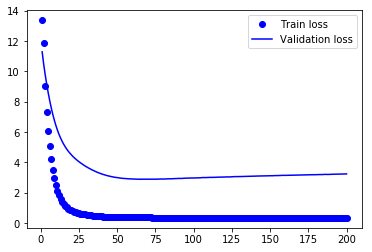

In [80]:
metric = history.history["loss"]
val_metric = history.history['val_' + "loss"]

e = range(1, EPOCHS + 1)

plt.plot(e, metric, 'bo', label='Train ' + "loss")
plt.plot(e, val_metric, 'b', label='Validation ' + "loss")
plt.legend()
plt.show()

In [81]:
user_id = 0
pred_X1 = np.array([user_id]*NUM_PRODUCTS).reshape(-1,1)
pred_X2 = np.array([i for i in range(NUM_PRODUCTS)]).reshape(-1,1)

In [82]:
user_ratings = rating_model.predict([pred_X1,pred_X2]).reshape(-1)

top_3_index = user_ratings.argsort()[-3:][::-1]

user_ratings[top_3_index]

array([6.005805 , 5.875758 , 5.8743486], dtype=float32)

In [85]:
user_ratings

array([5.257456  , 4.483857  , 3.908771  , ..., 0.18922853, 4.7145157 ,
       2.152554  ], dtype=float32)

In [86]:
class rator:
    def __init__(self,num_users,num_products,embed_size=20,pred_type='regression'):
        ### input layer
        if pred_type not in ['regression','classification']:
            raise Exception("Must select from regression or classification")
        self.embed_size = embed_size
        self.num_users = num_users
        self.num_products = num_products
        self.pred_type = pred_type

        self.model = self.build_model()
        
    def build_model(self):
        input_user = layers.Input(shape=(1,))
        input_product = layers.Input(shape=(1,))
        in_layers = [input_user,input_product]

        ### Embedding layer
        embed_user = layers.Embedding(self.num_users ,self.embed_size)(input_user)
        embed_product = layers.Embedding(self.num_products,self.embed_size)(input_product)

        ### flattern layer 
        flat_user = layers.Flatten()(embed_user)
        flat_product = layers.Flatten()(embed_product)

        ### Dot layer
        dot_value = layers.dot([flat_user,flat_product],axes=1,normalize=True)

        dense1 = layers.Dense(20)(dot_value)
        dense2 = layers.Dense(10)(dense1)

        if self.pred_type == "classification" :
            rating_y = layers.Dense(10,activation="softmax")(dense2)
        else:
            rating_y = layers.Dense(1)(dense2)
            
        ### Construct model
        self.rating_model = Model(inputs=in_layers,output=rating_y)
        if self.pred_type == "classification":
            self.rating_model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])
        else:
            self.rating_model.compile(loss="mse",optimizer="adam")
            
    def train(self,x,y,validation_split=0.2,epochs=200,batch_size=256):
        self.history = self.rating_model.fit(x=x,y=Y,validation_split=validation_split,epochs=epochs,batch_size=batch_size,verbose=1)

    def plot(self):
        metric_name = "acc" if self.pred_type == "classification" else "loss"
        
        metric = history.history[metric_name]
        val_metric = history.history['val_' + metric_name]

        e = range(1, EPOCHS + 1)

        plt.plot(e, metric, 'bo', label='Train ' + metric_name)
        plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
        plt.legend()
        plt.show()
        
    def recommend2User(self,userId,top_n=3):

        pred_X1 = np.array([userId]*self.num_products).reshape(-1,1)
        pred_X2 = np.array([i for i in range(self.num_products)]).reshape(-1,1)

        user_ratings = self.rating_model.predict([pred_X1,pred_X2]).reshape(-1)

        top_n_index = user_ratings.argsort()[-top_n:][::-1]

        top_n_ratings = user_ratings[top_n_index]
        
        return top_n_index,top_n_ratings

In [87]:
X = df[[userCol,productCol]].values
Y = df['rating'].values

X1 = X[:,0].reshape(-1,1)
X2 = X[:,1].reshape(-1,1)

In [88]:
"""Set up configuration for modeling"""
NUM_PRODUCTS = np.unique(X[:,1]).size
NUM_USERS = np.unique(X[:,0]).size
DIM_FEATURES = 10
EPOCHS = 200
BATCH_SIZE = 512
verbose = 1

In [89]:
myRator = rator(embed_size=20,num_products=NUM_PRODUCTS,num_users=NUM_USERS,pred_type="regression")

/Users/ricky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [90]:
myRator.train(x=[X1,X2],y=Y,batch_size=256,epochs=200,validation_split=0.8)

Train on 20164 samples, validate on 80659 samples
Epoch 1/200
20164/20164 [==============================] - 2s 112us/step - loss: 10.8564 - val_loss: 4.0333
Epoch 2/200
20164/20164 [==============================] - 2s 86us/step - loss: 1.5474 - val_loss: 1.5581
Epoch 3/200
20164/20164 [==============================] - 1s 60us/step - loss: 0.6423 - val_loss: 1.5838
Epoch 4/200
20164/20164 [==============================] - 1s 63us/step - loss: 0.5224 - val_loss: 1.6752
Epoch 5/200
20164/20164 [==============================] - 1s 71us/step - loss: 0.4473 - val_loss: 1.7719
Epoch 6/200
20164/20164 [==============================] - 2s 84us/step - loss: 0.3914 - val_loss: 1.8549
Epoch 7/200
20164/20164 [==============================] - 1s 67us/step - loss: 0.3494 - val_loss: 1.9375
Epoch 8/200
20164/20164 [==============================] - 1s 72us/step - loss: 0.3178 - val_loss: 1.9929
Epoch 9/200
20164/20164 [==============================] - 1s 65us/step - loss: 0.2936 - val_loss: 2

20164/20164 [==============================] - 1s 63us/step - loss: 0.1348 - val_loss: 2.6363
Epoch 78/200
20164/20164 [==============================] - 1s 63us/step - loss: 0.1339 - val_loss: 2.6169
Epoch 79/200
20164/20164 [==============================] - 1s 64us/step - loss: 0.1337 - val_loss: 2.6988
Epoch 80/200
20164/20164 [==============================] - 1s 63us/step - loss: 0.1327 - val_loss: 2.5707
Epoch 81/200
20164/20164 [==============================] - 1s 62us/step - loss: 0.1328 - val_loss: 2.6678
Epoch 82/200
20164/20164 [==============================] - 1s 63us/step - loss: 0.1322 - val_loss: 2.6576
Epoch 83/200
20164/20164 [==============================] - 1s 65us/step - loss: 0.1324 - val_loss: 2.7046
Epoch 84/200
20164/20164 [==============================] - -6s -300us/step - loss: 0.1327 - val_loss: 2.6863
Epoch 85/200
20164/20164 [==============================] - 1s 65us/step - loss: 0.1316 - val_loss: 2.6539
Epoch 86/200
20164/20164 [=====================

20164/20164 [==============================] - 1s 61us/step - loss: 0.1176 - val_loss: 2.9608
Epoch 154/200
20164/20164 [==============================] - 1s 65us/step - loss: 0.1170 - val_loss: 2.9524
Epoch 155/200
20164/20164 [==============================] - 1s 64us/step - loss: 0.1160 - val_loss: 2.9765
Epoch 156/200
20164/20164 [==============================] - 1s 61us/step - loss: 0.1161 - val_loss: 2.9361
Epoch 157/200
20164/20164 [==============================] - 1s 69us/step - loss: 0.1158 - val_loss: 2.9730
Epoch 158/200
20164/20164 [==============================] - 1s 64us/step - loss: 0.1160 - val_loss: 2.9784
Epoch 159/200
20164/20164 [==============================] - 1s 69us/step - loss: 0.1156 - val_loss: 3.0188
Epoch 160/200
20164/20164 [==============================] - 1s 62us/step - loss: 0.1157 - val_loss: 3.0260
Epoch 161/200
20164/20164 [==============================] - 1s 65us/step - loss: 0.1155 - val_loss: 2.9835
Epoch 162/200
20164/20164 [===============

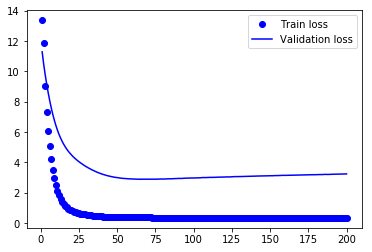

In [91]:
myRator.plot()

In [92]:
myRator.recommend2User(userId=1,top_n=10)

(array([3801, 1418,  246, 5378, 3806,  205, 6227, 7589, 6698, 7252]),
 array([7.380048 , 7.2703943, 7.259532 , 7.209813 , 7.208133 , 7.1014113,
        7.091375 , 7.069335 , 7.023509 , 6.941768 ], dtype=float32))